# Q-learning with Neural Networks

In this demo, we will explain q-learning with neural networks for an agent that plays the game Gridworld. Gridworld is a simple game with a 4x4 grid of tiles and 4 objects placed therein: a player, pit, goal, and a wall. The player can move up/down/left/right and the point of the game is to get to the goal where the player will receive a numerical reward. Unfortunately, we have to avoid a pit, because if we land on the pit we are penalized with a negative 'reward'. As if our task wasn't difficult enough, there's also a wall that can block the player's path (but it offers no reward or penalty).

<img src="../images/gridworld.png">

### Actions
* 0 -> up
* 1 -> down
* 2 -> left
* 3 -> right

In [6]:
%run Gridworld.py

state = initGrid()
print(dispGrid(state))

[[' ' 'P' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']]


In [7]:
state=initGrid()
print(dispGrid(state))
state = makeMove(state, 3) #right
print(dispGrid(state))
state = makeMove(state, 3) #right
print(dispGrid(state))
state = makeMove(state, 1) #down
print(dispGrid(state))
state = makeMove(state, 1) #down
print(dispGrid(state))
state = makeMove(state, 1) #down
print('Reward: %s' % (getReward(state),))

[[' ' 'P' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']]
[[' ' ' ' 'P' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']]
[[' ' ' ' ' ' 'P']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']]
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' 'P']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']]
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' ' ' ' ' '+']]
Reward: 10


## Q-Learning

## Neural Network as our Q function

### State

For every object, we hve a 4x4 grid and we display its position with a 1 and 0 everywhere else. Since we have 4 obejcts we get four 4x4 grids. We can verctorize those representations by unfolding the grids and appending them to each other. This results in a vector of size 64 (4x4x4).

<img src="../images/gridpositions.png">


### Network

* The input of the neural network is the state vector of length 64, therefore out input layer has 64 nodes.
* We use 2 hidden layers both with 20 nodes (Note: This is a best guess architecture and many other architectures are possible)
* The output layer of the neural network has the size of the number of actions (in this case 4)
* All layers are fully connected (dense) since our input is not an image, therefore we have no convolution layers.


<img src="../images/rl3net.png">

* For the hidden layers we use the "relu" activation function
* For the output layer we use a linear activation function (Todo explain why, together with value function)

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [3]:
model = Sequential()

# 2 hidden layers both with 20 nodes, 64 input nodes
model.add(Dense(20, activation='relu', kernel_initializer='lecun_uniform', input_shape=(64,)))
model.add(Dense(20, activation='relu', kernel_initializer='lecun_uniform'))

# Use linear activation for q-values
model.add(Dense(4, activation='linear', kernel_initializer='lecun_uniform'))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)

In [8]:
model.predict(state.reshape(1,64), batch_size=1)

array([[ 0.11044043,  0.06371572,  0.11758504, -0.10322978]], dtype=float32)

### Train Agent


Below is the implementation for the main loop of the algorithm. In broad strokes:
1. Setup a for-loop to number of epochs
2. In the loop, setup while loop (while game is in progress)
3. Run Q network forward.
4. We're using an epsilon greedy implementation, so at time _t_ with probability $\epsilon$ we will choose a random action. With probability $1-\epsilon$ we will choose the action associated with the highest Q value from our neural network.
5. Take action $a$ as determined in (4), observe new state $s'$ and reward $r_{t+1}$
6. Run the network forward using $s'$. Store the highest Q value (`maxQ`).
7. Our target value to train the network is `reward + (gamma * maxQ)` where `gamma` is a parameter ($0 <= \gamma <= 1$).
8. Given that we have 4 outputs and we only want to update/train the output associated with the action we just took, our target output vector is the same as the output vector from the first run, except we change the one output associated with our action to: `reward + (gamma * maxQ)`
9. Train the model on this 1 sample. Repeat process 2-9

In [9]:
from IPython.display import clear_output
import random

epochs = 300
gamma = 0.9 #since it may take several moves to goal, making gamma high
epsilon = 1
rewards = []
for i in range(epochs):
    
    state = initGrid()
    status = 1
    #while game still in progress
    last_reward = 0
    while(status == 1):
        #We are in state S
        #Let's run our Q function on S to get Q values for all possible actions
        qval = model.predict(state.reshape(1,64), batch_size=1)
        if (random.random() < epsilon): #choose random action
            action = np.random.randint(0,4)
        else: #choose best action from Q(s,a) values
            action = (np.argmax(qval))
        #Take action, observe new state S'
        new_state = makeMove(state, action)
        #Observe reward
        reward = getReward(new_state)
        #Get max_Q(S',a)
        newQ = model.predict(new_state.reshape(1,64), batch_size=1)
        maxQ = np.max(newQ)
        y = np.zeros((1,4))
        y[:] = qval[:]
        if reward == -1: #non-terminal state
            update = (reward + (gamma * maxQ))
        else: #terminal state
            update = reward
        y[0][action] = update #target output
        print("Game #: %s Eps: %.2f" % (i,epsilon))
        model.fit(state.reshape(1,64), y, batch_size=1, nb_epoch=1, verbose=1)
        state = new_state
        if reward != -1:
            status = 0
            last_reward = reward
            rewards.append(reward)
        print("Reward: %d" % (last_reward))
        clear_output(wait=True)
    if epsilon > 0.1:
        epsilon -= (1/epochs)


Game #: 299 Eps: 0.10
Epoch 1/1
1/1 [==============================] - 0s - loss: 6.1613
Reward: -10


__Plot Rewards__

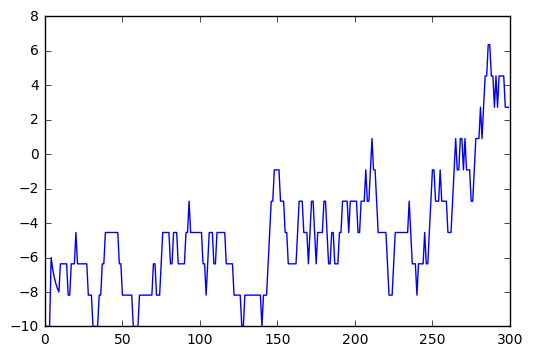

In [10]:
import matplotlib.pyplot as plt
mean_rewards = []
for i in range(len(rewards)):
    mean_rewards.append(np.mean(rewards[max(i-10, 0):i+1]))
plt.plot(mean_rewards)
plt.show()

### Test Agent

In [11]:
def testAlgo(init=0):
    i = 0
    if init==0:
        state = initGrid()
    elif init==1:
        state = initGridPlayer()
    elif init==2:
        state = initGridRand()

    print("Initial State:")
    print(dispGrid(state))
    status = 1
    reward = -10
    #while game still in progress
    while(status == 1):
        qval = model.predict(state.reshape(1,64), batch_size=1)
        action = (np.argmax(qval)) #take action with highest Q-value
        print('Move #: %s; Taking action: %s' % (i, action))
        state = makeMove(state, action)
        print(dispGrid(state))
        reward = getReward(state)
        if reward != -1:
            status = 0
            print("Reward: %s" % (reward,))
        i += 1 #If we're taking more than 10 actions, just stop, we probably can't win this game
        if (i > 10):
            print("Game lost; too many moves.")
            break
    return reward

In [13]:
testAlgo(init=0)

Initial State:
[[' ' 'P' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']]
Move #: 0; Taking action: 3
[[' ' ' ' 'P' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']]
Move #: 1; Taking action: 3
[[' ' ' ' ' ' 'P']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']]
Move #: 2; Taking action: 1
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' 'P']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']]
Move #: 3; Taking action: 1
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' ' ' ' ' '+']]
Move #: 4; Taking action: 1
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Reward: 10


10

## Experience Replay

1. In state $s$, take action $a$, observe new state $s_{t+1}$ and reward $r_{t+1}$
2. Store this as a tuple $(s, a, s_{t+1}, r_{t+1})$ in a list.
3. Continue to store each experience in this list until we have filled the list to a specific length (up to you to define)
4. Once the experience replay memory is filled, randomly select a subset (e.g. 40)
5. Iterate through this subset and calculate value updates for each; store these in a target array (e.g. `y_train`) and store the state $s$ of each memory in `X_train`
6. Use `X_train` and `y_train` as a minibatch for batch training. For subsequent epochs where the array is full, just overwrite old values in our experience replay memory array.

Thus, in addition to learning the action-value for the action we just took, we're also going to use a random sample of our past experiences to train on to prevent catastrophic forgetting.


In [14]:
model.compile(loss='mse', optimizer=rms)#reset weights of neural network
epochs = 150
gamma = 0.975
epsilon = 1
batchSize = 8
buffer = 32
replay = []
#stores tuples of (S, A, R, S')
h = 0
rewards = []
for i in range(epochs):
    
    state = initGridPlayer() #using the harder state initialization function
    status = 1
    #while game still in progress
    while(status == 1):
        #We are in state S
        #Let's run our Q function on S to get Q values for all possible actions
        qval = model.predict(state.reshape(1,64), batch_size=1)
        if (random.random() < epsilon): #choose random action
            action = np.random.randint(0,4)
        else: #choose best action from Q(s,a) values
            action = (np.argmax(qval))
        #Take action, observe new state S'
        new_state = makeMove(state, action)
        #Observe reward
        reward = getReward(new_state)
        
        #Experience replay storage
        if (len(replay) < buffer): #if buffer not filled, add to it
            replay.append((state, action, reward, new_state))
        else: #if buffer full, overwrite old values
            if (h < (buffer-1)):
                h += 1
            else:
                h = 0
            replay[h] = (state, action, reward, new_state)
            #randomly sample our experience replay memory
            minibatch = random.sample(replay, batchSize)
            X_train = []
            y_train = []
            for memory in minibatch:
                #Get max_Q(S',a)
                old_state, action, reward, new_state = memory
                old_qval = model.predict(old_state.reshape(1,64), batch_size=1)
                newQ = model.predict(new_state.reshape(1,64), batch_size=1)
                maxQ = np.max(newQ)
                y = np.zeros((1,4))
                y[:] = old_qval[:]
                if reward == -1: #non-terminal state
                    update = (reward + (gamma * maxQ))
                else: #terminal state
                    update = reward
                y[0][action] = update
                X_train.append(old_state.reshape(64,))
                y_train.append(y.reshape(4,))
            
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            print("Game #: %s Eps: %.2f" % (i,epsilon))
            model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=1)
            state = new_state
        if reward != -1: #if reached terminal state, update game status
            status = 0
            rewards.append(reward)
        if len(rewards) > 0:
            print("Mean10 reward: %d" % (np.mean(rewards[max(i-10, 0):i+1])))
        clear_output(wait=True)
    if epsilon > 0.1: #decrement epsilon over time
        epsilon -= (1/epochs)

Game #: 149 Eps: 0.10
Epoch 1/1
8/8 [==============================] - 0s - loss: 9.5391
Mean10 reward: 2


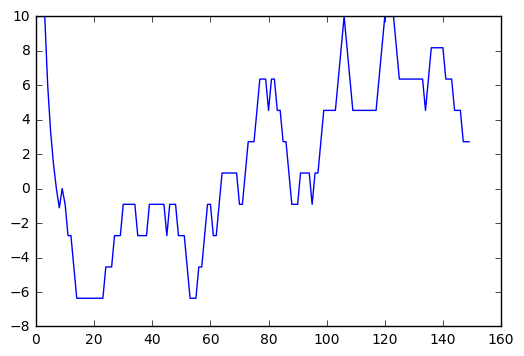

In [15]:
import matplotlib.pyplot as plt
mean_rewards = []
for i in range(len(rewards)):
    mean_rewards.append(np.mean(rewards[max(i-10, 0):i+1]))
plt.plot(mean_rewards)
plt.show()

In [137]:
testAlgo(init=1)

Initial State:
[[' ' ' ' ' ' 'P']
 [' ' '-' '+' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: 1
[[' ' ' ' ' ' ' ']
 [' ' '-' '+' 'P']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: 2
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Reward: 10


10

In [138]:
num_wins = 0
for i in range(100):
    if testAlgo(init=1) == 10:
        num_wins += 1
    clear_output(wait=True)
print("Num wins %d" % (num_wins))

Num wins 20
